# The objectives of the lab

The purpose of this lab is to reproduce tables 3.1 and 3.2 from the third chapter of the book "Elements of Statistical Learning" from Hastie, Tibshirani and Friedman, as shown bellow. The objective of the homework is to reproduce table 3.3.

## 1. Prepare the data : 
 
 Raw data is available on line, download it from  moodle ({\tt Data.txt} file) or from the web at 
https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data

!conda install -c conda-forge cvxpy

In [2]:
import pandas as pd

url_data = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(url_data, delimiter='\t') 

For some reason, data has to be normalized

In [3]:
variables = df.columns[1:9]
df[variables] = df[variables].apply(lambda x: (x - x.mean()) / x.std())

Split the data into training and test sets

In [4]:
# Get the training and test sets
Y_train = df.loc[df["train"]=="T", 'lpsa'].to_numpy()
X_train = df.loc[df["train"]=="T", variables].to_numpy()
print("Training set : n = {} samples and p = {} dimensions".format(X_train.shape[0], X_train.shape[1]))

Y_test = df.loc[df["train"]=="F", 'lpsa'].to_numpy()
X_test = df.loc[df["train"]=="F", variables].to_numpy()
print("Test set : n = {} samples and p = {} dimensions".format(X_test.shape[0], X_test.shape[1]))

Training set : n = 67 samples and p = 8 dimensions
Test set : n = 30 samples and p = 8 dimensions


## 2. Compute the correlation of the predictors in the cancer data

<Axes: >

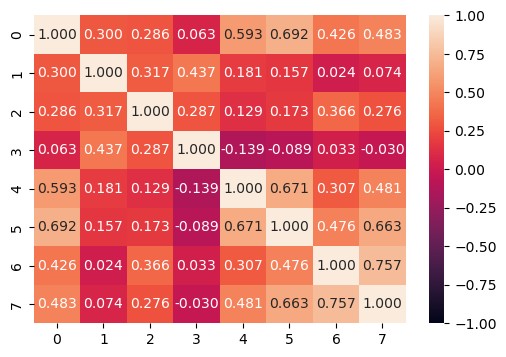

In [5]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Xn = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
n, p = Xn.shape
C = Xn.T@Xn/n
# or C = np.corrcoef(X_train.T)

plt.figure(figsize=(6, 4))
sns.heatmap(C, annot=True, fmt=".3f", vmin=-1)

## 3. Compute the linear fit to the prostate cancer data, the standart error assosiated with each coefficient and the corresponding Z score

In [6]:
X = np.concatenate( (np.ones((X_train.shape[0],1)), X_train), axis=1)
b_ls = np.linalg.solve(X.T@X, X.T@Y_train)

In [7]:
n, p = X.shape
y_hat = X@b_ls
sigma_square = np.dot(Y_train - y_hat, Y_train - y_hat)/(n-p)    
vector_v = np.diag(np.linalg.inv(X.T@X))
    
std_error_coef = np.sqrt(sigma_square * vector_v)
z_score = b_ls/(std_error_coef)

In [8]:
dash = '-' * 50
print(dash)
print("{:<11s}{:<15s}{:<14s}{:<10s}".format("Term",  "Coefficient", "Std. error","Z score"))
print(dash)
for k in range(variables.shape[0]+1):
    if k==0:
        print("{:<10s}{:>12.2f}{:>12.2f}{:>12.2f}".format("Intercept", b_ls[k], std_error_coef[k], z_score[k]))
    else:
        print("{:<10s}{:>12.2f}{:>12.2f}{:>12.2f}".format(variables[k-1], b_ls[k], std_error_coef[k], z_score[k]))
print(dash)

--------------------------------------------------
Term       Coefficient    Std. error    Z score   
--------------------------------------------------
Intercept         2.46        0.09       27.60
lcavol            0.68        0.13        5.37
lweight           0.26        0.10        2.75
age              -0.14        0.10       -1.40
lbph              0.21        0.10        2.06
svi               0.31        0.12        2.47
lcp              -0.29        0.15       -1.87
gleason          -0.02        0.15       -0.15
pgg45             0.27        0.15        1.74
--------------------------------------------------


<img src = "https://i.stack.imgur.com/epSz4.png">

## Best subset 

In [9]:
X = np.concatenate( (np.ones((X_train.shape[0],1)), X_train[:,0:2]), axis=1)
b_bs = np.zeros(p)
b_bs[0:3] = np.linalg.solve(X.T@X, X.T@Y_train)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ", b_bs)

Estimation:  [ 2.477  0.740  0.316  0.000  0.000  0.000  0.000  0.000  0.000]


## Ridge

It differs from the regession by the use of a $\ell_2$-norm regularization on the parameters
$$
\min_{\beta_0, \, \beta} \sum_{i=1}^n \left(y_i - \beta_0 - x_i^\top \beta \right)^2 + \lambda \sum_{j=1}^p \beta_j^2
$$


In [11]:
ybar = Y_train.mean()
stdy = Y_train.std()
xbar = X_train.mean(0)
stdx = X_train.std(0)
Xc = X_train - xbar
Yc = Y_train - ybar
lam = 24.25
b_R = np.linalg.solve(Xc.T@Xc + lam*np.eye(p-1), Xc.T@Yc)
b0_R = ybar 
#b0_R = ybar - xbar.T@b_R # should be this
beta_R = np.concatenate((np.array([b0_R]), b_R), axis=0)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ", beta_R)
b0_R = ybar - xbar.T@b_R
print(b0_R)

Estimation:  [ 2.452  0.420  0.238 -0.047  0.162  0.227  0.001  0.041  0.132]
2.4641208076992855


In [10]:
X = np.concatenate( (np.ones((X_train.shape[0],1)), X_train), axis=1)
I = np.eye(p)
I[0,0] = 0
beta_R2 = np.linalg.solve(X.T@X + lam*I, X.T@Y_train)
print("Estimation: ", beta_R2)

Estimation:  [ 2.464  0.420  0.238 -0.047  0.162  0.227  0.001  0.041  0.132]


In [11]:
import cvxpy as cp

lam = 24.25
b = cp.Variable(p-1)
b0 = cp.Variable(1)

o = cp.Minimize(cp.sum_squares(b0+X_train@b-Y_train) + lam*cp.sum_squares(b))
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)

beta_R3 = np.concatenate((np.array(b0.value),b.value))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",beta_R3)

(CVXPY) Sep 08 06:43:25 PM: Encountered unexpected exception importing solver OSQP:
ImportError("dlopen(/Users/stephane/anaconda3/lib/python3.11/site-packages/osqp/_osqp.cpython-311-darwin.so, 0x0002): symbol not found in flat namespace '_csc_matrix'")
Estimation:  [ 2.464  0.420  0.238 -0.047  0.162  0.227  0.001  0.041  0.132]


## Lasso regression
It differs from the ridge regession by the use of a $\ell_1$-norm regularization on the parameters
$$
\min_{\beta_0, \, \beta} \sum_{i=1}^n \left(y_i - \beta_0 - x_i^\top \beta \right)^2 + \lambda \sum_{j=1}^p |\beta_j|
$$
An equivalent formulation (due to convexity of the fitting error term and the regularization) is:
\begin{eqnarray}
\min_{\beta_0, \, \beta} & \sum_{i=1}^n \left(y_i - \beta_0 - x_i^\top \beta \right)^2 \\
s.t. & \sum_{j=1}^p |\beta_j| \leq t
\end{eqnarray}

In [12]:
import cvxpy as cp

Xn = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
Yn = (Y_train - Y_train.mean())/Y_train.std()
t = .7015
n, p = Xn.shape

b = cp.Variable(p)
o = cp.Minimize(cp.sum_squares(Xn@b-Yn))
c = [cp.norm(b, 1) <= t]
problem = cp.Problem(o, c)
problem.solve(solver=cp.SCS,eps=1e-5)

ybar = Y_train.mean()
stdy = Y_train.std()
xbar = X_train.mean(0)
stdx = X_train.std(0)
b0_lasso =  ybar - stdy*((xbar/stdx).T@b.value)
b_lasso = b.value*Y_train.std()/X_train.std(axis=0)
beta_lasso = np.concatenate((np.array([b0_lasso]),b_lasso))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",beta_lasso)

Estimation:  [ 2.468  0.533  0.169  0.000  0.002  0.094  0.000  0.000  0.000]


In [13]:
lam = c[0].dual_value
print(lam)    # lam = 23.38
o = cp.Minimize(cp.sum_squares(Xn@b-Yn) + lam*cp.norm(b, 1))
problem = cp.Problem(o)
problem.solve(solver=cp.SCS,eps=1e-5)

b0_lasso =  ybar - stdy*((xbar/stdx).T@b.value)
b_lasso = b.value*Y_train.std()/X_train.std(axis=0)
beta_lasso = np.concatenate((np.array([b0_lasso]),b_lasso))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Estimation: ",beta_lasso)

23.38565605099124
Estimation:  [ 2.468  0.533  0.169 -0.000  0.002  0.094 -0.000 -0.000 -0.000]


## PCR

In [14]:
U, s, Vt = np.linalg.svd(Xn, full_matrices=False, compute_uv=True)
Z = U*s
theta = Z.T@Yn/np.diag(Z.T@Z)
k = 7
b_PCR = Vt.T[:,:k]@theta[:k]

ybar = Y_train.mean()
stdy = Y_train.std()
xbar = X_train.mean(0)
stdx = X_train.std(0)
b0_PCR =  ybar - stdy*((xbar/stdx).T@b_PCR)
b_PCR = b_PCR/X_train.std(axis=0)*stdy
beta_PCR = np.concatenate((np.array([b0_PCR]),b_PCR))
print("Estimation: ",beta_PCR)

Estimation:  [ 2.497  0.541  0.291 -0.153  0.214  0.318 -0.050  0.233 -0.061]


## PLS

In [19]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression(n_components=2,scale=False)  # really better results with n_components=3
#pls2.fit(Xn, Yn)
X_train_1 = np.hstack((np.ones((n,1)),X_train))
pls2.fit(X_train_1, Y_train)
nt = X_test.shape[0]
X_test_1 = np.hstack((np.ones((nt,1)),0*X_test))
Y_pred = pls2.predict(X_test_1)

pls2.coef_[0] = Y_pred[0]    # 2.452 - it doesn't fit the book !
beta_pls = pls2.coef_.flatten()
print(beta_pls)

[ 2.467  0.419  0.345 -0.026  0.220  0.243  0.078  0.011  0.084]


/Users/stephane/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


## Test error

In [20]:
X_test_1 = np.hstack((np.ones((nt,1)),X_test))
B = np.stack((b_ls.T , b_bs.T , beta_R.T , beta_lasso.T, beta_PCR.T, beta_pls.T)).T
ytp = X_test_1@B
err = ytp - np.outer(Y_test,np.ones(6))
testErr = np.mean(err**2,axis=0)

StdErr = np.std(err**2,axis=0, ddof=1)/np.sqrt(nt)

In [21]:
dash = '-' * 84
print(dash)
print("{:<18s}{:<8s}{:<15s}{:<12s}{:<13s}{:<12s}{:<10s}".format("Term", "LS", "Best Subset", "Ridge", "Lasso", "PCR", "PLS"))
print(dash)
for k in range(variables.shape[0]+1):
    if k==0:
        print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format("Intercept", B[0,0],B[0,1],B[0,2],B[0,3],B[0,4],B[0,5]))
    else:
        print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format(variables[k-1],B[k,0],B[k,1],B[k,2],B[k,3],B[k,4],B[k,5]))
print(dash)
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format("Test Error",testErr[0],testErr[1],testErr[2],testErr[3],testErr[4],testErr[5]))
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format("Std Error",StdErr[0],StdErr[1],StdErr[2],StdErr[3],StdErr[4],StdErr[5]))
print(dash)

------------------------------------------------------------------------------------
Term              LS      Best Subset    Ridge       Lasso        PCR         PLS       
------------------------------------------------------------------------------------
Intercept        2.465       2.477       2.452       2.468       2.497       2.467
lcavol           0.680       0.740       0.420       0.533       0.541       0.419
lweight          0.263       0.316       0.238       0.169       0.291       0.345
age             -0.141       0.000      -0.047      -0.000      -0.153      -0.026
lbph             0.210       0.000       0.162       0.002       0.214       0.220
svi              0.305       0.000       0.227       0.094       0.318       0.243
lcp             -0.288       0.000       0.001      -0.000      -0.050       0.078
gleason         -0.021       0.000       0.041      -0.000       0.233       0.011
pgg45            0.267       0.000       0.132      -0.000      -0.061       

<img src = "https://i.stack.imgur.com/4Nooa.png">

## Improve the PLS results

In [22]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression(n_components=3,scale=False)  # really better results with n_components=3
#pls2.fit(Xn, Yn)
X_train_1 = np.hstack((np.ones((n,1)),X_train))
pls2.fit(X_train_1, Y_train)
nt = X_test.shape[0]
X_test_1 = np.hstack((np.ones((nt,1)),0*X_test))
Y_pred = pls2.predict(X_test_1)

pls2.coef_[0] = Y_pred[0]    # 2.452
beta_pls = pls2.coef_.flatten()
print(beta_pls)

X_test_1 = np.hstack((np.ones((nt,1)),X_test))
B = np.stack((b_ls.T , b_bs.T , beta_R.T , beta_lasso.T, beta_PCR.T, beta_pls.T)).T
ytp = X_test_1@B
err = ytp - np.outer(Y_test,np.ones(6))
testErr = np.mean(err**2,axis=0)

StdErr = np.std(err**2,axis=0, ddof=1)/np.sqrt(nt)

dash = '-' * 84
print(dash)
print("{:<18s}{:<8s}{:<15s}{:<12s}{:<13s}{:<12s}{:<10s}".format("Term", "LS", "Best Subset", "Ridge", "Lasso", "PCR", "PLS"))
print(dash)
for k in range(variables.shape[0]+1):
    if k==0:
        print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format("Intercept", B[0,0],B[0,1],B[0,2],B[0,3],B[0,4],B[0,5]))
    else:
        print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format(variables[k-1],B[k,0],B[k,1],B[k,2],B[k,3],B[k,4],B[k,5]))
print(dash)
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format("Test Error",testErr[0],testErr[1],testErr[2],testErr[3],testErr[4],testErr[5]))
print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}".format("Std Error",StdErr[0],StdErr[1],StdErr[2],StdErr[3],StdErr[4],StdErr[5]))
print(dash)

[ 2.483  0.576  0.279 -0.179  0.201  0.299 -0.036  0.006  0.117]
------------------------------------------------------------------------------------
Term              LS      Best Subset    Ridge       Lasso        PCR         PLS       
------------------------------------------------------------------------------------
Intercept        2.465       2.477       2.452       2.468       2.497       2.483
lcavol           0.680       0.740       0.420       0.533       0.541       0.576
lweight          0.263       0.316       0.238       0.169       0.291       0.279
age             -0.141       0.000      -0.047      -0.000      -0.153      -0.179
lbph             0.210       0.000       0.162       0.002       0.214       0.201
svi              0.305       0.000       0.227       0.094       0.318       0.299
lcp             -0.288       0.000       0.001      -0.000      -0.050      -0.036
gleason         -0.021       0.000       0.041      -0.000       0.233       0.006
pgg45       

/Users/stephane/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
